# 1. Основные качества выборки

На входе мы имеем датасет с набором нарезанных кадров из различных видео с железнодорожных площадок, ну и также разметку в формате yolo, на данный момент правда неизвестно какие именно классы необходимо научиться детектировать, так что первым делом необходимо по разметке определить какие-же объекты необходимо детектировать, и как они указаны в разметке.

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os

from random import randint
from matplotlib.pyplot import figure

In [28]:
def read_data(path: str) -> pd.DataFrame:
    results = []

    filenames = os.listdir(path)
    for filename in filenames:
        if filename[-3:] == 'txt':
            continue

        image_file_path = os.path.join(path, filename)
        markup_file_path = os.path.join(path, filename[:-3] + 'txt')
        results.append((image_file_path, markup_file_path))

    return pd.DataFrame(results)

def get_markup_from_file(file_path):
    markup = []
    with open(file_path, 'r') as markup_file:
        lines = markup_file.readlines()
        for line in lines:
            split_line = line.split(' ')
            class_index = int(split_line[0])
            coords = list(map(float, split_line[1:]))
            markup.append((class_index, coords))
    return markup
    
def convert_yolo_to_cv_rect(coords: list, image_width: int, image_height: int) -> list:
    abs_x = int((coords[0] - coords[2] / 2) * image_width)
    abs_y = int((coords[1] - coords[3] / 2) * image_height)

    abs_width = int(coords[2] * image_width)
    abs_height = int(coords[3] * image_height)

    return ((abs_x, abs_y), (abs_x + abs_width, abs_y + abs_height))

In [107]:
df = read_data('train_data')
df.columns = ['img_path', 'markup_path']

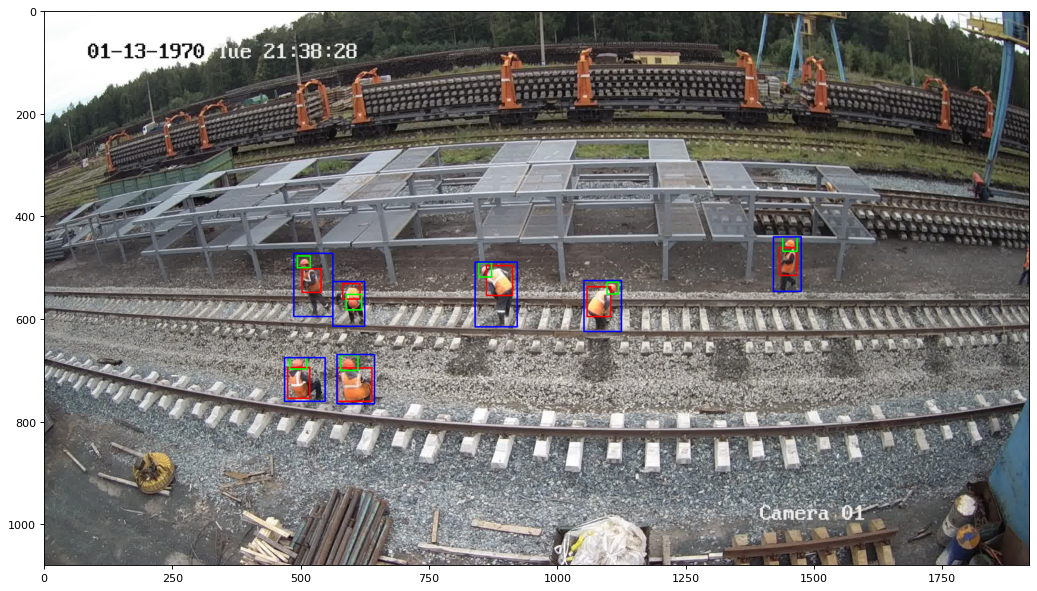

In [39]:
figure(figsize=(16, 9), dpi=80)
colors = {0: (0, 0, 255), 1: (0, 255, 0), 2: (255, 0, 0)}

elem = df.iloc[randint(0, len(df) - 1)]

image = cv2.imread(elem[0])
markup = get_markup_from_file(elem[1])
for class_index, coords in markup:
    abs_coords = convert_yolo_to_cv_rect(coords, image.shape[1], image.shape[0])
    cv2.rectangle(image, abs_coords[0], abs_coords[1], colors[class_index], 2)

plt.imshow(image[:, :, ::-1])

Исходя из полученной картинки можно увидеть, что классы объектов, которые предстоит детектировать - это человек(2), жилет(0) и каска(1).

In [140]:
image_sizes = df['img_path'].apply(lambda x: cv2.imread(x).shape[:2])
image_sizes.value_counts()

(1080, 1920)    3222
Name: img_path, dtype: int64

Также теперь мы можем увидеть, что всего у нас в наличии 3222 изображения, разрешением 1920x1080

# 2. Изучение изображений

Наличие чистой выборки в виде изображений является крайне важной задачей для обучения любой нейросети, и поэтому первым делом был проведен поверхностный осмотр выборки. В результате данного осмотра было выявляно два момента:
1. Присутствуют изображения без людей - такие изображения не являются какой-то проблемой, и в самом фреймворке Darknet, что такие изобраения имеют смысл и помогают улучшить точность. Но важно убедиться, что такие изображения не составляют значительную долю всей выборки.
2. Однообразность выборки

## 2.1. Кадры без разметки

In [112]:
df['has_markup'] = df['markup_path'].apply(lambda x: len(get_markup_from_file(x)) != 0)
print('Общее кол-во изображений:', len(df))
print('Кол-во изображений без объектов:', len(df) - df['has_markup'].sum())
print('Доля изображений без объектов:', 1 - (df['has_markup'].sum() / len(df)))

Общее кол-во изображений: 3222
Кол-во изображений без объектов: 157
Доля изображений без объектов: 0.048727498448168816


Итого, мы имеем, что количество изображений без каких-либо объектов равно 157 из всех 3222 изображений, или же около 5% всей выборки. Такая ситуация не критична, поэтому лишних действий не требуется.

## 2.2. Однообразность выборки

При просмотре иображений выборки стало очевидно, что выборка само по себе крайне однообразна - ракурсы камеры крайне похожи, то же самое с локациями. Такое однозначно приведет к низкой универсальности и позволит работать нейросети, только на тех же камерах, что были в выборке. Поэтому можно зараанее даже сказать, что точность у модели на новых данных, которые будут взяты из других источников будет не самая лучшая.

# 3. Изучение разметки

Разметка изображений конечно же также является важной частью датасета, и грязная разметка также может помешать обучению. Важными вопросами качества для разметки YOLO являются:
1. Баланс классов объектов
2. Размеры боксов

## 3.1. Баланс классов объектов

Для качества выборки имеет сильную важность баланс классов, так как это позволяет иметь хорошую точность в среднем на всех объектах. В то время как, если одного класса будет значительно больше в датасете, то скорее всего появятся проблемы с тем, что при обучении сеть будет чаще видеть определенный класс и поэтому сильнее обучится именно на него, в то время как точность остальных классов будет страдать. Поэтому необходимо опеределить качество имеющейся выборки через кол-во классов объектов.

In [121]:
classes = ['Жилет', 'Каска', 'Человек']
markup_list = []
for i in range(len(df)):
    elem = df.iloc[i]
    markup = get_markup_from_file(elem[1])
    for box in markup:
        markup_list.append((elem[0], elem[1], box[0], classes[box[0]], box[1][0], box[1][1], box[1][2], box[1][3]))
        
df_markup = pd.DataFrame(markup_list)
df_markup.columns = ['img_path', 'markup_path', 'class_idx', 'class_label', 'x_center', 'y_center', 'width', 'height']
df_markup

,img_path,markup_path,class_idx,class_label,x_center,y_center,width,height
0,train_data\00000002.jpg,train_data\00000002.txt,0,Жилет,0.740625,0.551389,0.018750,0.027778
1,train_data\00000002.jpg,train_data\00000002.txt,0,Жилет,0.729688,0.379861,0.012500,0.034722
2,train_data\00000002.jpg,train_data\00000002.txt,1,Каска,0.733594,0.358333,0.007812,0.016667
3,train_data\00000002.jpg,train_data\00000002.txt,2,Человек,0.730078,0.386806,0.019531,0.076389
4,train_data\00000002.jpg,train_data\00000002.txt,2,Человек,0.739844,0.575000,0.029687,0.083333
...,...,...,...,...,...,...,...,...
22366,train_data\9_0000017.jpg,train_data\9_0000017.txt,0,Жилет,0.970600,0.517000,0.014400,0.037500
22367,train_data\9_0000019.jpg,train_data\9_0000019.txt,2,Человек,0.953100,0.503700,0.025600,0.080400
22368,train_data\9_0000019.jpg,train_data\9_0000019.txt,2,Человек,0.977800,0.521100,0.024200,0.066200
22369,train_data\9_0000019.jpg,train_data\9_0000019.txt,0,Жилет,0.954800,0.490400,0.015800,0.040100


In [141]:
print('Кол-во объектов детекции:', len(df_markup))

Кол-во объектов детекции: 22371


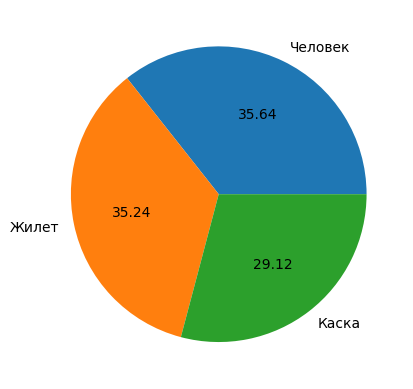

In [132]:
class_balance = df_markup['class_label'].value_counts()
plt.pie(x=class_balance, labels=class_balance.keys(), autopct='%.2f')
plt.show()

Из полученных данных можно увидеть, что первыми по численности являются классы объектов "Человек" и "Жилет" и занимаю примерно по 36% и 35% выборки соответственно, в то время как класс "Каска" занимает оставшиеся 29%. Вряд ли подобное распределение можно назвать значительным дисбалансом, поэтому можно считать, что в целом классы объектов сбалансированы 

## 3.2. Размеры и координаты объектов

Важной моментов у всех выборок, связанных с детектированием, является размер и координаты объектов в кадре. Это важно по двум причинам:
1. Корректность координат и размеров - здесь имеется ввиду отсутствие выходов координат за границы кадра, или же отсутствие каких-либо отрицательных значений
2. Нормальные размеры боксов - тут имеется ввиду отсутствие каких-либо рамок размеров несколько пикселей, такие рамки будет невозможно адекватно классифицировать, что будет приводить к ухудшению точности 

### 3.2.1. Корректность рамок

In [148]:
is_x_center_out = (df_markup['x_center'] > 1).sum() + (df_markup['x_center'] < 0).sum() > 0
is_y_center_out = (df_markup['y_center'] > 1).sum() + (df_markup['y_center'] < 0).sum() > 0
is_width_out = (df_markup['width'] > 1).sum() + (df_markup['width'] < 0).sum() > 0
is_height_out = (df_markup['height'] > 1).sum() + (df_markup['height'] < 0).sum() > 0

print(is_x_center_out, is_y_center_out, is_width_out, is_height_out)

False False False False


Из проверки координат на выход за границы изображения, видим, что в этом плане все корректно

In [156]:
is_right_bound_out = ((df_markup['x_center'] + df_markup['width'] / 2) > 1).sum() > 0
is_left_bound_out = ((df_markup['x_center'] - df_markup['width'] / 2) < 0).sum() > 0
is_top_bound_out = ((df_markup['y_center'] + df_markup['height'] / 2) > 1).sum() > 0
is_bottom_bound_out = ((df_markup['y_center'] - df_markup['height'] / 2) < 0).sum() > 0

print(is_right_bound_out, is_left_bound_out, is_top_bound_out, is_bottom_bound_out)

True True True False


В случае проверки на выход рамок в целом за границу кадра видно, что далеко не все рамки оказались корректными. На самом деле - это не является значительной ошибкой и вряд ли сильно повлияет на результаты обучения, но раз такое было замечено, то очевидно, что эти моменты перед обучением стоит почистить.

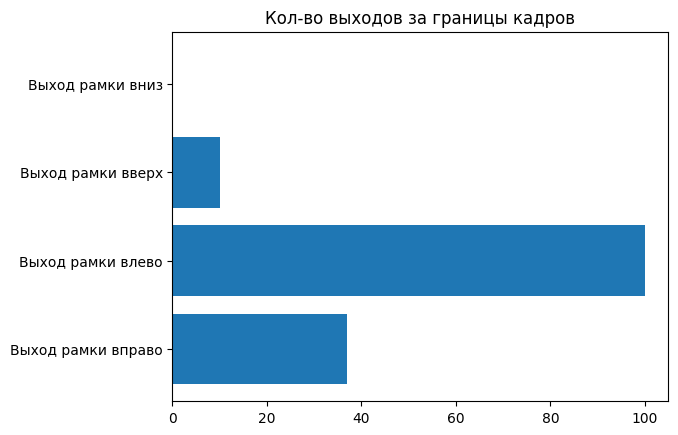

In [189]:
right_bound_out = df_markup[((df_markup['x_center'] + df_markup['width'] / 2) > 1)]
left_bound_out = df_markup[((df_markup['x_center'] - df_markup['width'] / 2) < 0)]
top_bound_out = df_markup[((df_markup['y_center'] + df_markup['height'] / 2) > 1)]
bottom_bound_out = df_markup[((df_markup['y_center'] - df_markup['height'] / 2) < 0)]

outs = [len(right_bound_out), len(left_bound_out), len(top_bound_out), len(bottom_bound_out)]
plt.barh([0, 1, 2, 3], width=outs)
plt.yticks([0, 1, 2, 3], ['Выход рамки вправо', 'Выход рамки влево',
                          'Выход рамки вверх', 'Выход рамки вниз'])
plt.title('Кол-во выходов за границы кадров')
plt.show()

### 3.2.2. Размеры рамок

В данной секции нас интересует момент, связанный с размерами рамок объектов по классам. Такое исследование позволит определить возможные проблемы с некоторыми классами, в нашем случае крайне опасным классом являются каски, из-за того, что они имеют маленькие рамки, и на некоторых кадрах могут быть совсем неразличимы.

Также изучение размеров позволит нам принять решение о модификации YOLOv4 для обучения. Здесь имеется ввиду момент, который описывается во фрреймворке о детекции маленьких объектов:


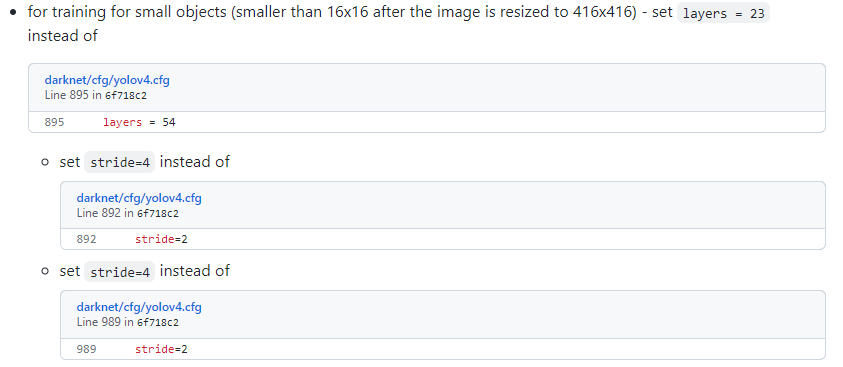


Поэтому для получения площади будут использовать значения ширины и высоты: 416 и 416

In [202]:
df_markup['abs_x'] = df_markup['x_center'] * 416
df_markup['abs_y'] = df_markup['y_center'] * 416
df_markup['abs_width'] = df_markup['width'] * 416
df_markup['abs_height'] = df_markup['height'] * 416
df_markup['abs_area'] = df_markup['abs_width'] *  df_markup['abs_height']

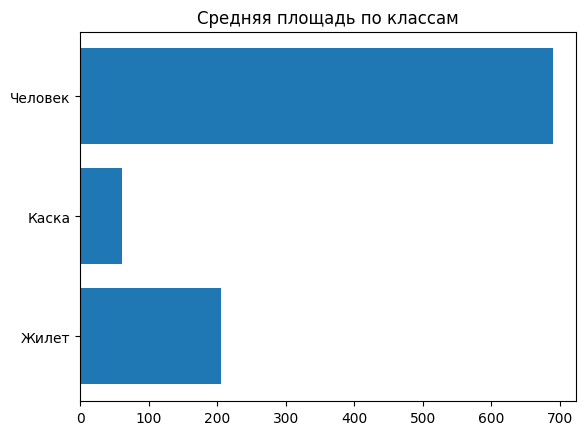

In [206]:
area_mean_distribution = df_markup.groupby('class_label')['abs_area'].mean()

plt.barh([0, 1, 2], width=area_mean_distribution)
plt.yticks([0, 1, 2], area_mean_distribution.keys())
plt.title('Средняя площадь по классам')
plt.show()

Из данного графика видно, что каски и жилеты ожидаемо занимают небольшую площадь в среднем в рамках 16x16 пикселей, но все же класс человека в этом плане имеет достаточную среднюю площадь.

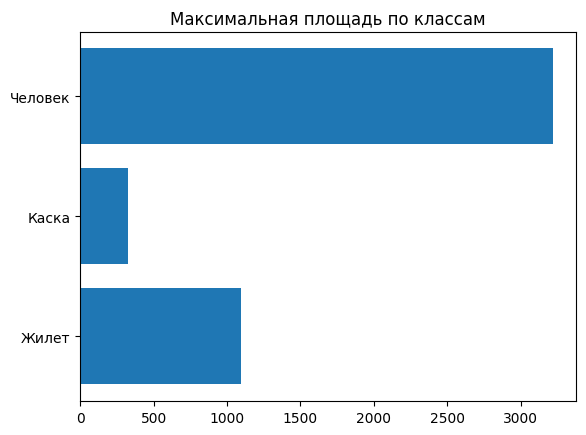

In [243]:
area_max_distribution = df_markup.groupby('class_label')['abs_area'].max()

plt.barh([0, 1, 2], width=area_max_distribution)
plt.yticks([0, 1, 2], area_max_distribution.keys())
plt.title('Максимальная площадь по классам')
plt.show()

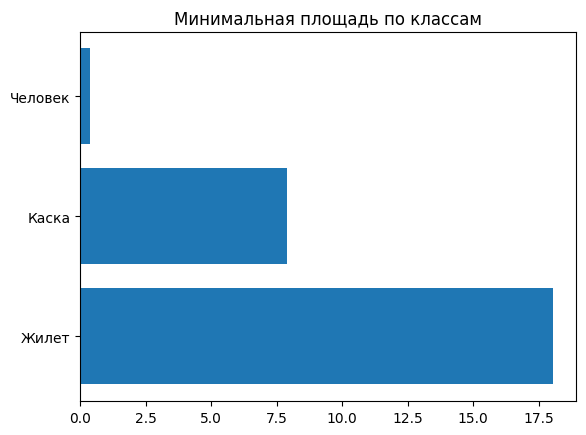

In [208]:
area_min_distribution = df_markup.groupby('class_label')['abs_area'].min()

plt.barh([0, 1, 2], width=area_min_distribution)
plt.yticks([0, 1, 2], area_min_distribution.keys())
plt.title('Минимальная площадь по классам')
plt.show()

Также интересно, что у нас в выборке присутствуют объекты с дейтвительно аномально маленькой площадью, к примеру какая-та рамка человека после ресайза при обучении будет занимать где-то один пиксель - очевидно, что такой объект невозможно адекватно распознавать и он требует чистки. В следствии таких находок далее стоит изучить кол-ва объектов в рамках определенных площадей.

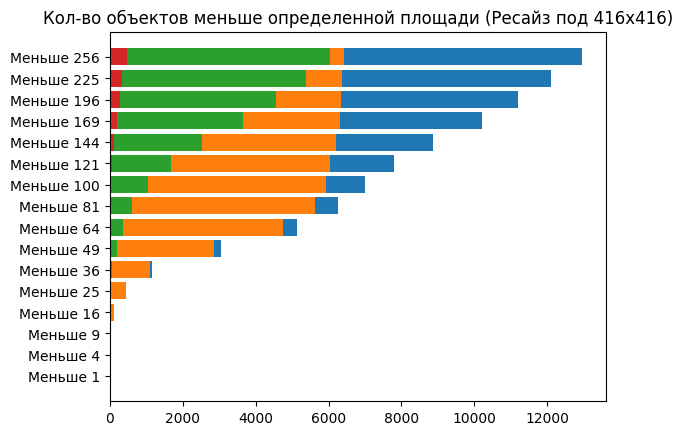

In [255]:
areas_under, labels = [], []
for i in range(1, 17):
    areas_under.append((df_markup['abs_area'] < i * i).sum())
    labels.append(f'Меньше {i * i}')
    
plt.barh(range(len(areas_under)), width=areas_under)
plt.yticks(range(len(areas_under)), labels)
plt.title('Кол-во объектов меньше определенной площади (Ресайз под 416x416)')

areas_under, labels = [], []
for i in range(1, 17):
    areas_under.append((df_markup[df_markup['class_idx'] == 1]['abs_area'] < i * i).sum())
    labels.append(f'Меньше {i * i}')
plt.barh(range(len(areas_under)), width=areas_under)

areas_under, labels = [], []
for i in range(1, 17):
    areas_under.append((df_markup[df_markup['class_idx'] == 0]['abs_area'] < i * i).sum())
    labels.append(f'Меньше {i * i}')
plt.barh(range(len(areas_under)), width=areas_under)

areas_under, labels = [], []
for i in range(1, 17):
    areas_under.append((df_markup[df_markup['class_idx'] == 2]['abs_area'] < i * i).sum())
    labels.append(f'Меньше {i * i}')
plt.barh(range(len(areas_under)), width=areas_under)

plt.show()

На данном графике была проведен расчет кол-ва объектов с площадью меньше определенной, брались количества до 256 пикселей. Отсюда можно видеть, что больше половины всех объектов по площади занимают меньше 256 пикселей после ресайза на 416x416. При этом почти всю эту часть занимают жилеты и каски Это значительное кол-во - отсюда можно принять два решения:
1. Применить модификацию для маленьких объектов (описана выше)
2. Увеличить разрешение

С первым решением проблема, что немотря на половину маленьких объектов, мы также имеем около половины больших объектов и в описании фреймворка говорится, что для такого случая лучше использовать стандартную модель YOLOv4

Со вторым решением проблема в том, что сильно увеличить разрешение нельзя, тогда пострадает время обучения и инференса. Имеет смысл посмотреть изменение площадей при использовании другого разрешения, рекомендуемого в фреймворке - 608x608.

In [244]:
df_markup['abs_x_608'] = df_markup['x_center'] * 608
df_markup['abs_y_608'] = df_markup['y_center'] * 608
df_markup['abs_width_608'] = df_markup['width'] * 608
df_markup['abs_height_608'] = df_markup['height'] * 608
df_markup['abs_area_608'] = df_markup['abs_width_608'] *  df_markup['abs_height_608']

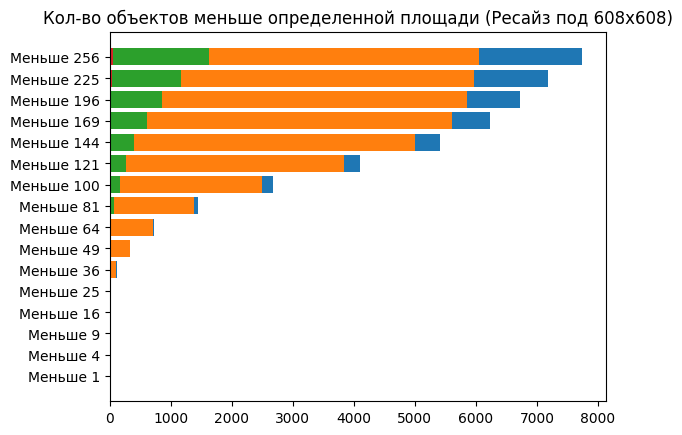

In [256]:
areas_under, labels = [], []
for i in range(1, 17):
    areas_under.append((df_markup['abs_area_608'] < i * i).sum())
    labels.append(f'Меньше {i * i}')
    
plt.barh(range(len(areas_under)), width=areas_under)
plt.yticks(range(len(areas_under)), labels)
plt.title('Кол-во объектов меньше определенной площади (Ресайз под 608x608)')

areas_under, labels = [], []
for i in range(1, 17):
    areas_under.append((df_markup[df_markup['class_idx'] == 1]['abs_area_608'] < i * i).sum())
    labels.append(f'Меньше {i * i}')
plt.barh(range(len(areas_under)), width=areas_under)

areas_under, labels = [], []
for i in range(1, 17):
    areas_under.append((df_markup[df_markup['class_idx'] == 0]['abs_area_608'] < i * i).sum())
    labels.append(f'Меньше {i * i}')
plt.barh(range(len(areas_under)), width=areas_under)

areas_under, labels = [], []
for i in range(1, 17):
    areas_under.append((df_markup[df_markup['class_idx'] == 2]['abs_area_608'] < i * i).sum())
    labels.append(f'Меньше {i * i}')
plt.barh(range(len(areas_under)), width=areas_under)

plt.show()

На данном графике очевидны улучшения, уже только треть объектов занимают площадь меньше 256 пикселей, при этом большинство этих классов занимают каски, классы человека почти полность вышли за границы 16x16, и значительно сократилась доля жилетов на этом графике. Ну и также каски несмотря н свою большую долю, все равно увеличились в разрешении и почти все перешли за 64 пикселя, а так как каска все же более менее простой объект - это кажется достаточным.

Также уже упоминалось, что объекты с сильно маленькими размерами требуют чистки, поэтому все изображения с объектами площадью меньше 25 будут удалены, а именно:

In [263]:
df_markup[df_markup['abs_area_608'] < 25]['img_path']

817        train_data\00000350.jpg
5551     train_data\13_0000007.jpg
5637     train_data\13_0000031.jpg
5647     train_data\13_0000033.jpg
5652     train_data\13_0000034.jpg
5655     train_data\13_0000035.jpg
5668     train_data\13_0000039.jpg
5716     train_data\13_0000053.jpg
5719     train_data\13_0000054.jpg
12227    train_data\18_0000001.jpg
12331    train_data\18_0000025.jpg
12394    train_data\18_0000033.jpg
12533    train_data\18_0000054.jpg
12927    train_data\20_0000011.jpg
12964    train_data\20_0000013.jpg
13492    train_data\20_0000052.jpg
13769    train_data\20_0000063.jpg
13798    train_data\20_0000064.jpg
13824    train_data\20_0000065.jpg
13846    train_data\20_0000066.jpg
13915    train_data\20_0000069.jpg
13962    train_data\20_0000071.jpg
13981    train_data\20_0000073.jpg
Name: img_path, dtype: object

# 4. Выводы

Делая выводы, после проведения EDA:
1. Были выбраны настройки модели для обучения
2. Были найдены аномалии и проблемы выборки, которые необходимо скорректировать
3. Были изучены основные свойства выборки

Стоит также отметить, что у выборки есть однозначные нерешаемые проблемы:
1. Низкое разнообразие - отсутствие универсальности
2. Маленькое кол-во изображений - 3000 не очень много для YOLO
3. Увеличение выборки путем аугментаций изображений различными искажениями невозможно из-за низких размеров касок (их и так будет не так просто распознать без аугментаций, с ними это может стать большой проблемой)

Отсюда можно сказать, что несмотря на все предпринятые шаги по решению проблем выборки, после обучения каких-то идеальных результатов ожидать не стоит.

# 5. Чистка датасета

In [300]:
for img_path in df_markup[df_markup['abs_area_608'] < 25]['img_path']:
    os.remove(img_path)
    os.remove(img_path[:-3] + 'txt')

In [297]:
for i in right_bound_out.index:
    elem = df_markup.iloc[i]
    with open(elem[1], 'r') as file:
        lines = file.readlines()
        
    for j, line in enumerate(lines):
        if str(elem[4]) in line:
            lines[j] = f'{elem[2]} {elem[4]} {elem[5]} {(1 - elem[4]) * 2} {elem[7]}\n'
            print(lines[j])
            
    with open(elem[1], 'w') as file:
        file.writelines(lines)
            
# left_bound_out
# top_bound_out

2 0.9903 0.5171 0.019400000000000084 0.0822

1 0.997266 0.423611 0.005468000000000028 0.016667

1 0.9953129999999999 0.42430599999999996 0.009374000000000215 0.018056

0 0.987891 0.9055559999999999 0.024218000000000073 0.069444

2 0.9800780000000001 0.9486109999999999 0.03984399999999977 0.088889

2 0.982813 0.949306 0.034373999999999905 0.073611

0 0.984766 0.915972 0.03046799999999994 0.051389

2 0.9781250000000001 0.91875 0.043749999999999734 0.081944

2 0.9800780000000001 0.9125 0.03984399999999977 0.072222

1 0.9941410000000002 0.897222 0.011717999999999673 0.033333

2 0.971094 0.922917 0.057811999999999975 0.093056

2 0.9773440000000001 0.913889 0.0453119999999998 0.080556

2 0.9773440000000001 0.913194 0.0453119999999998 0.073611

2 0.9800780000000001 0.911111 0.03984399999999977 0.075

1 0.9937500000000001 0.941667 0.012499999999999734 0.036111

2 0.975391 0.949306 0.049217999999999984 0.073611

2 0.9781250000000001 0.9486109999999999 0.043749999999999734 0.072222

1 0.99531299

In [298]:
for i in left_bound_out.index:
    elem = df_markup.iloc[i]
    with open(elem[1], 'r') as file:
        lines = file.readlines()

    for j, line in enumerate(lines):
        if str(elem[4]) in line:
            lines[j] = f'{elem[2]} {elem[4]} {elem[5]} {elem[4] * 2} {elem[7]}\n'
            print(lines[j])

    with open(elem[1], 'w') as file:
        file.writelines(lines)

0 0.012109 0.964583 0.024218 0.051389

2 0.030859000000000004 0.684028 0.06171800000000001 0.12361099999999998

0 0.008984 0.670139 0.017968 0.076389

0 0.007812 0.677778 0.015624 0.069444

2 0.015234 0.686806 0.030468 0.106944

0 0.0079 0.6075 0.0158 0.051

1 0.0028 0.449 0.0056 0.0189

1 0.002734 0.449306 0.005468 0.0125

1 0.0024 0.4494 0.0048 0.0175

1 0.002734 0.451389 0.005468 0.016667

1 0.002734 0.450694 0.005468 0.015278

1 0.002734 0.45 0.005468 0.013889

2 0.010937 0.482639 0.021874 0.079167

2 0.0114 0.4775 0.0228 0.0824

2 0.0107 0.4761 0.0214 0.0806

0 0.005859 0.457639 0.011718 0.026389

0 0.0025 0.4703 0.005 0.0362

0 0.0032 0.465 0.0064 0.0363

2 0.0101 0.4654 0.0202 0.0751

2 0.0093 0.4649 0.0186 0.0785

2 0.0093 0.4649 0.0186 0.0785

2 0.0093 0.4649 0.0186 0.0785

2 0.0093 0.4649 0.0186 0.0785

1 0.0028 0.4318 0.0056 0.0165

0 0.006 0.4573 0.012 0.0318

2 0.012 0.4703 0.024 0.0835

2 0.012 0.4703 0.024 0.0835

1 0.0028 0.4323 0.0056 0.0189

0 0.0057 0.4594 0.0114 0.0

In [299]:
for i in top_bound_out.index:
    elem = df_markup.iloc[i]
    with open(elem[1], 'r') as file:
        lines = file.readlines()

    for j, line in enumerate(lines):
        if str(elem[4]) in line:
            lines[j] = f'{elem[2]} {elem[4]} {elem[5]} {elem[6]} {(1 - elem[5]) * 2}\n'
            print(lines[j])

    with open(elem[1], 'w') as file:
        file.writelines(lines)

2 0.030078 0.9618060000000002 0.057031000000000005 0.07638799999999968

0 0.077344 0.986806 0.01875 0.026388000000000078

2 0.4051 0.9105 0.0712 0.17900000000000005

2 0.890625 0.9430559999999999 0.057813 0.11388800000000021

1 0.8796870000000001 0.985417 0.01875 0.029166000000000025

0 0.943359 0.986806 0.024219 0.026388000000000078

0 0.9003910000000002 0.9888890000000001 0.036718999999999995 0.022221999999999742

0 0.902344 0.9680560000000001 0.032812 0.06388799999999972

0 0.052733999999999996 0.980556 0.03671900000000001 0.038888000000000034

2 0.029297000000000004 0.9430559999999999 0.05703099999999999 0.11388800000000021



In [292]:
left_bound_out

,img_path,markup_path,class_idx,class_label,x_center,y_center,width,height
1694,train_data\1021.jpg,train_data\1021.txt,0,Жилет,0.012109,0.964583,0.024219,0.051389
5299,train_data\137.jpg,train_data\137.txt,2,Человек,0.030859,0.684028,0.061719,0.123611
7976,train_data\157.jpg,train_data\157.txt,0,Жилет,0.008984,0.670139,0.017969,0.076389
8522,train_data\161.jpg,train_data\161.txt,0,Жилет,0.007812,0.677778,0.015625,0.069444
8967,train_data\165.jpg,train_data\165.txt,2,Человек,0.015234,0.686806,0.030469,0.106944
...,...,...,...,...,...,...,...,...
20772,train_data\7_0000014.jpg,train_data\7_0000014.txt,0,Жилет,0.005300,0.475400,0.011600,0.062100
20776,train_data\7_0000015.jpg,train_data\7_0000015.txt,2,Человек,0.010300,0.490100,0.021300,0.131500
20780,train_data\7_0000015.jpg,train_data\7_0000015.txt,1,Каска,0.002200,0.435700,0.006000,0.021800
20783,train_data\7_0000015.jpg,train_data\7_0000015.txt,0,Жилет,0.006100,0.477600,0.013400,0.065000
